# Задание 1 по дисциплине машинное обучение для анализа научных данных


## Самсонов Александр Александрович

### Загрузка и очистка данных

In [1]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
link = "https://www.kaggle.com/competitions/spaceship-titanic"

od.download(link)
data = pd.read_csv("./spaceship-titanic/train.csv", sep=",")
print(data.shape)

Skipping, found downloaded files in "./spaceship-titanic" (use force=True to force download)
(8693, 14)


In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### Заполним или выкинем нулл значения

In [4]:
data.drop("Name", inplace=True, axis=1)
data.isna().sum()
# Name is most definitely not important, let's drop it right away

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [5]:
print(f"Останется {data.dropna().shape[0] / data.shape[0]} колонок, где нет нулл значений") 

Останется 0.7780973196825032 колонок, где нет нулл значений


12% - многовато. Сохраню для экспериментов копию без нулей и копию с заполненными самым вероятностным значением

In [6]:
notna_data = data.dropna(inplace=False)
mean_values = dict()
for col in notna_data.columns[1:]:
    mean_values[col] = notna_data[col].mode().tolist()[0]

In [7]:
mean_values

{'HomePlanet': 'Earth',
 'CryoSleep': False,
 'Cabin': 'B/11/S',
 'Destination': 'TRAPPIST-1e',
 'Age': 24.0,
 'VIP': False,
 'RoomService': 0.0,
 'FoodCourt': 0.0,
 'ShoppingMall': 0.0,
 'Spa': 0.0,
 'VRDeck': 0.0,
 'Transported': True}

In [8]:
for col, val in mean_values.items():
    data[col].fillna(val, inplace=True)

data.isna().sum()

/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/3699468933.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(val, inplace=True)
/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/3699468933.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col].fillna(val

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

Проигнорируем Future warning, это нам не к чему беспокоиться сейчас

#### Займемся кодированием

Описание некоторых колонок: 
- PassengerId - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
- Cabin - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Я планирую применять дерево выборов, в соответствии с этим я выберу соответствующие способы кодирования

In [9]:
data[["PassengerGroup", 'PassengerNumber']] = data["PassengerId"].str.split("_", expand=True)
data[["deck", "num", 'side']] = data["Cabin"].str.split("/", expand=True)
data.drop(["Cabin", "PassengerId"], axis=1, inplace=True)
data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerNumber,deck,num,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S


Кастим типы данных, смотрим сколько у нас категорий в признаках, посмотрим где какие энкодеры лучше применить

In [10]:
data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].astype("float16") 
data[["PassengerGroup", "PassengerNumber", "num"]] = data[["PassengerGroup", "PassengerNumber", "num"]].astype(int, errors="ignore")

In [11]:
data.select_dtypes(exclude=["number", "int", "float16"]).nunique()

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
Transported    2
deck           8
side           2
dtype: int64

Номер кабины (num) не является категориальной, также сделаем его int и посмотрим на распределение остальных категорий, применим binary encoding к данным о планетах. На deck можно применить label encoding. Остальное - можно просто скастить в булевы переменные (точнее в int, так как keras dataframe не работает с булевыми в любом случае)

In [12]:
data['num'] = data["num"].astype(int, errors="ignore")
data[["CryoSleep", "VIP", "Transported"]] = data[["CryoSleep", "VIP", "Transported"]].astype(bool, errors="ignore").astype(int)
data["side"] = (data["side"] == "S").astype(int)
data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerNumber,deck,num,side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,B,0,0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,1,F,0,1
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6716.0,49.0,0,3,1,A,0,1
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3328.0,193.0,0,3,2,A,0,1
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4,1,F,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41.0,1,0.0,6820.0,0.0,1643.0,74.0,0,9276,1,A,98,0
8689,Earth,1,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,0,9278,1,G,1499,1
8690,Earth,0,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,9279,1,G,1500,1
8691,Europa,0,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3236.0,0,9280,1,E,608,1


In [13]:
from sklearn.preprocessing import LabelBinarizer

data["deck"] = data["deck"].apply(lambda x: ord(x)-65)

data[["HomePlanet0", "HomePlanet1", "HomePlanet2"]] = LabelBinarizer().fit_transform(data["HomePlanet"])
data[["Destination0", "Destination1", "Destination2"]] = LabelBinarizer().fit_transform(data["Destination"])
data.drop(["Destination", "HomePlanet"], axis=1, inplace=True)
data


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerNumber,deck,num,side,HomePlanet0,HomePlanet1,HomePlanet2,Destination0,Destination1,Destination2
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0,0,0,1,0,0,0,1
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,1,5,0,1,1,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6716.0,49.0,0,3,1,0,0,1,0,1,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3328.0,193.0,0,3,2,0,0,1,0,1,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4,1,5,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6820.0,0.0,1643.0,74.0,0,9276,1,0,98,0,0,1,0,1,0,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,9278,1,6,1499,1,1,0,0,0,1,0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,9279,1,6,1500,1,1,0,0,0,0,1
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3236.0,0,9280,1,4,608,1,0,1,0,1,0,0


Создадим единую для этого процедуру, чтобы потом применить на notna подмножестве

In [14]:
def spaceship_encoding(data: pd.DataFrame) -> pd.DataFrame:
    data[["PassengerGroup", 'PassengerNumber']] = data["PassengerId"].str.split("_", expand=True)
    data[["deck", "num", 'side']] = data["Cabin"].str.split("/", expand=True)
    
    data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].astype("float16") 
    data[["PassengerGroup", "PassengerNumber", "num"]] = data[["PassengerGroup", "PassengerNumber", "num"]].astype(int, errors="ignore")
    data[["CryoSleep", "VIP", "Transported"]] = data[["CryoSleep", "VIP", "Transported"]].astype(bool, errors="ignore").astype(int)
    data["side"] = (data["side"] == "S").astype(int)
    data["deck"] = data["deck"].apply(lambda x: ord(x)-65) #  ord("A") = 65. Magic number, don't cate

    data[["HomePlanet0", "HomePlanet1", "HomePlanet2"]] = LabelBinarizer().fit_transform(data["HomePlanet"])
    data[["Destination0", "Destination1", "Destination2"]] = LabelBinarizer().fit_transform(data["Destination"])
    
    data["spendingsSum"] = data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
    
    data.drop(["Cabin", "PassengerId", "Destination", "HomePlanet"], axis=1, inplace=True)
    
    return data

In [15]:
notna_data = spaceship_encoding(notna_data)
notna_data

/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/3766077578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["PassengerGroup", 'PassengerNumber']] = data["PassengerId"].str.split("_", expand=True)
/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/3766077578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["PassengerGroup", 'PassengerNumber']] = data["PassengerId"].str.split("_", expand=True)
/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/376

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,...,deck,num,side,HomePlanet0,HomePlanet1,HomePlanet2,Destination0,Destination1,Destination2,spendingsSum
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,1,0,0,0,1,0,0,0,1,0.0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,...,5,0,1,1,0,0,0,0,1,736.0
2,0,58.0,1,43.0,3576.0,0.0,6716.0,49.0,0,3,...,0,0,1,0,1,0,0,0,1,10384.0
3,0,33.0,0,0.0,1283.0,371.0,3328.0,193.0,0,3,...,0,0,1,0,1,0,0,0,1,5176.0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4,...,5,1,1,1,0,0,0,0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6820.0,0.0,1643.0,74.0,0,9276,...,0,98,0,0,1,0,1,0,0,8536.0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,9278,...,6,1499,1,1,0,0,0,1,0,0.0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,9279,...,6,1500,1,1,0,0,0,0,1,1873.0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3236.0,0,9280,...,4,608,1,0,1,0,1,0,0,4640.0


### Визуализация

Заново загружу данные для визуализации, а предобработку проведу перед обучением алгоритма

In [16]:
data = pd.read_csv("./spaceship-titanic/train.csv", sep=",")

for col, val in mean_values.items():
    data[col].fillna(val, inplace=True)

data["spendingsSum"] = data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

data[["deck", "num", 'side']] = data["Cabin"].str.split("/", expand=True)

data[["num"]] = data[["num"]].astype(int, errors="ignore")

data[["CryoSleep", "VIP", "Transported"]] = data[["CryoSleep", "VIP", "Transported"]].astype(bool, errors="ignore").astype(int)

data["side"] = (data["side"] == "S").astype(int)

data["deck"] = data["deck"].apply(lambda x: ord(x)-65)

data.drop(["Name", "Cabin", "PassengerId", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1, inplace=True)

/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/3492582225.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(val, inplace=True)
/var/folders/82/8g_0rbdn4_x9dq7f41hyyzsc0000gn/T/ipykernel_80907/3492582225.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col].fillna(val

In [17]:
data

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,spendingsSum,deck,num,side
0,Europa,0,TRAPPIST-1e,39.0,0,0,0.0,1,0,0
1,Earth,0,TRAPPIST-1e,24.0,0,1,736.0,5,0,1
2,Europa,0,TRAPPIST-1e,58.0,1,0,10383.0,0,0,1
3,Europa,0,TRAPPIST-1e,33.0,0,0,5176.0,0,0,1
4,Earth,0,TRAPPIST-1e,16.0,0,1,1091.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41.0,1,0,8536.0,0,98,0
8689,Earth,1,PSO J318.5-22,18.0,0,0,0.0,6,1499,1
8690,Earth,0,TRAPPIST-1e,26.0,0,1,1873.0,6,1500,1
8691,Europa,0,55 Cancri e,32.0,0,0,4637.0,4,608,1


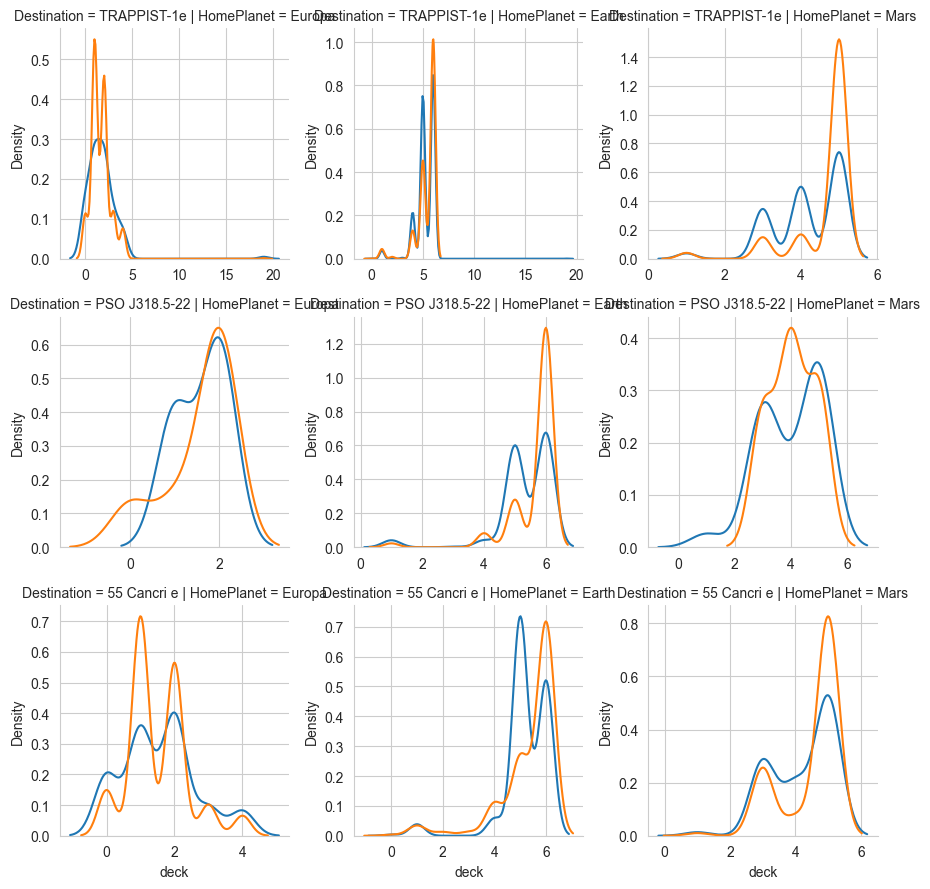

In [18]:
g = sns.FacetGrid(data, 
                  hue="Transported",
                  col="HomePlanet", 
                  row="Destination",
                  sharex=False, sharey=False)
g.map(sns.kdeplot,
      "deck")

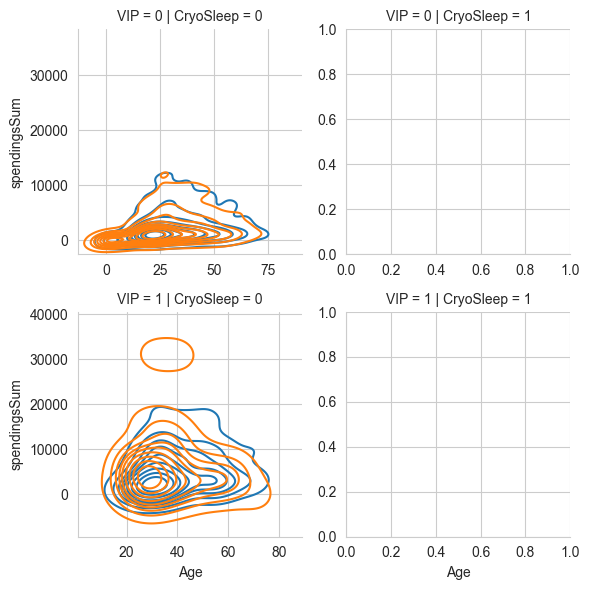

In [19]:
g = sns.FacetGrid(data, 
                  hue="Transported",
                  col="CryoSleep", 
                  row="VIP",
                  sharex=False, sharey=False)
g.map(sns.kdeplot,
      "Age", "spendingsSum", warn_singular=False)

Сложно усмотреть явные паттерны. Посмотрим на распределения всех категорий и их корреляцию 

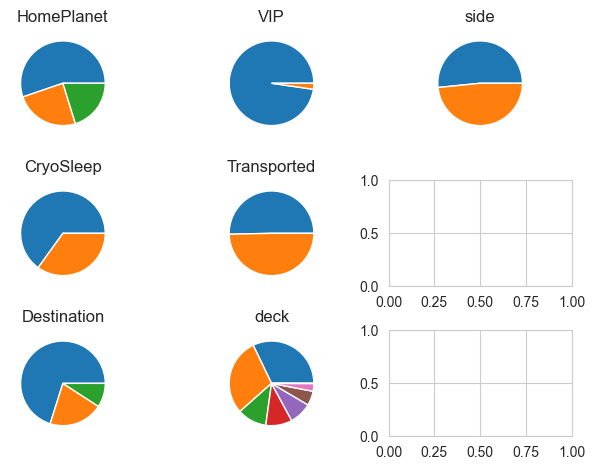

In [60]:
fig, ax = plt.subplots(3, 3, sharey=False, sharex=False)

for i, val in enumerate(["HomePlanet", "CryoSleep", "Destination", "VIP", "Transported", "deck", "side"]):
    ax[i%3][i//3].pie(data[val].value_counts())
    ax[i%3][i//3].set_title(val)

fig.tight_layout()
